In [1]:
from gr00t.utils.eval import calc_mse_for_single_trajectory
import warnings
from gr00t.experiment.data_config import DATA_CONFIG_MAP
from gr00t.model.policy import L1Gr00tPolicy
from gr00t.data.schema import EmbodimentTag
from gr00t.data.dataset import LeRobotSingleDataset
import numpy as np
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

warnings.simplefilter("ignore", category=FutureWarning)

/home/longnh/anaconda3/envs/gr00t/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
2025-04-21 11:32:00.295867: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-21 11:32:00.295908: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-21 11:32:00.313287: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-21 11:32:00.356

In [7]:
PRE_TRAINED_MODEL_PATH = "nvidia/GR00T-N1-2B"
L1_GR00T_MODEL_PATH = "./"
EMBODIMENT_TAG = EmbodimentTag.GR1
DATASET_PATH = "../../../demo_data/robot_sim.PickNPlace"


data_config = DATA_CONFIG_MAP["gr1_arms_only"]
data_config.action_indices = list(range(-4, 16))
modality_config = data_config.modality_config()
modality_transform = data_config.transform()


dataset = LeRobotSingleDataset(
    dataset_path=DATASET_PATH,
    modality_configs=modality_config,
    video_backend="decord",
    video_backend_kwargs=None,
    transforms=None,  # We'll handle transforms separately through the policy
    embodiment_tag=EMBODIMENT_TAG,
    training=False
)


Initialized dataset robot_sim.PickNPlace with EmbodimentTag.GR1


In [3]:
pre_trained_policy = L1Gr00tPolicy(
    l1_model_path=L1_GR00T_MODEL_PATH,
    model_path=PRE_TRAINED_MODEL_PATH,
    embodiment_tag=EMBODIMENT_TAG,
    modality_config=modality_config,
    modality_transform=modality_transform,
    device=device,
)

Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Loading pretrained dual brain from /home/longnh/.cache/huggingface/hub/models--nvidia--GR00T-N1-2B/snapshots/32e1fd2507f7739fad443e6b449c8188e0e02fcb
Tune backbone vision tower: True
Tune backbone LLM: False
Tune action head projector: True
Tune action backbone: True
Model not found or avail in the huggingface hub. Loading from local path: /home/longnh/.cache/huggingface/hub/models--nvidia--GR00T-N1-2B/snapshots/32e1fd2507f7739fad443e6b449c8188e0e02fcb
Total number of action backbone's parameters:  453206016


Some weights of L1_GR00T_N1 were not initialized from the model checkpoint at /home/longnh/.cache/huggingface/hub/models--nvidia--GR00T-N1-2B/snapshots/32e1fd2507f7739fad443e6b449c8188e0e02fcb and are newly initialized: ['action_head.action_embedding.weight', 'action_head.action_encoder.layer1.W', 'action_head.action_encoder.layer1.b', 'action_head.action_encoder.layer2.W', 'action_head.action_encoder.layer2.b', 'action_head.position_embedding.pe']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of L1_GR00T_N1 were not initialized from the model checkpoint at /home/longnh/.cache/huggingface/hub/models--nvidia--GR00T-N1-2B/snapshots/32e1fd2507f7739fad443e6b449c8188e0e02fcb and are newly initialized because the shapes did not match:
- action_head.action_decoder.layer1.W: found shape torch.Size([32, 1024, 1024]) in the checkpoint and torch.Size([32, 1536, 1024]) in the model instantiated
You should probably TRAIN 

Tune action head projector: True
Tune action head backbone: True
Tune action head projector: True
Tune action head backbone: True


Using 4 past actions
inferencing at step:  0
inferencing at step:  16
inferencing at step:  32
inferencing at step:  48
inferencing at step:  64
inferencing at step:  80
inferencing at step:  96
inferencing at step:  112
inferencing at step:  128
inferencing at step:  144
Unnormalized Action MSE across single traj: 1.9132105465192641
Average inference time per action: 0.008626616795857748
Average inference time per action_horizon: 0.14377694659762913


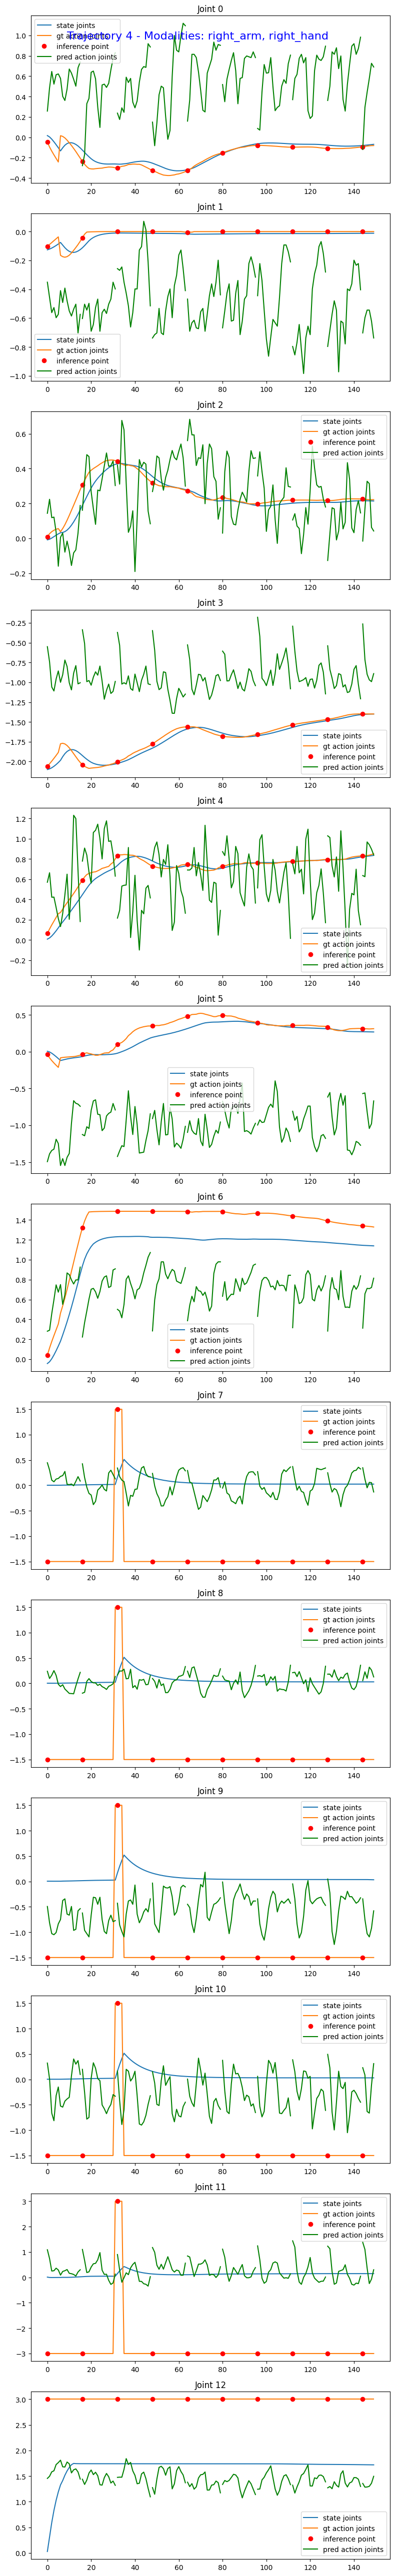

MSE loss for trajectory 0: 1.9132105465192641


In [8]:
mse = calc_mse_for_single_trajectory(
    pre_trained_policy,
    dataset,
    traj_id=4,
    modality_keys=["right_arm", "right_hand"],   # we will only evaluate the right arm and right hand
    steps=150,
    action_horizon=16,
    plot=True,
    num_past_actions=4
)

print("MSE loss for trajectory 0:", mse)

Finetune commands: `python scripts/l1_gr00t_finetune.py --dataset-path ./demo_data/robot_sim.PickNPlace --num-gpus 1 --max-steps 2000 --output-dir checkpoints/l2_gr00t-with-4-past-actions/finetuned-model --data-config gr1_arms_only --num_past_actions 4`

In [9]:
from gr00t.utils.eval import calc_mse_for_single_trajectory
import warnings

finetuned_model_path = "../../checkpoints/l2_gr00t-with-past-actions/finetuned-model/checkpoint-500"
finetuned_policy = L1Gr00tPolicy(
    l1_model_path=finetuned_model_path,
    model_path=finetuned_model_path,
    embodiment_tag="new_embodiment",
    modality_config=modality_config,
    modality_transform=modality_transform,
    device=device,
)

warnings.simplefilter("ignore", category=FutureWarning)

mse = calc_mse_for_single_trajectory(
    finetuned_policy,
    dataset,
    traj_id=0,
    modality_keys=["right_arm", "right_hand"],   # we will only evaluate the right arm and right hand
    steps=150,
    action_horizon=16,
    plot=True
)

print("MSE loss for trajectory 0:", mse)

Model not found or avail in the huggingface hub. Loading from local path: ../../checkpoints/l2_gr00t-with-past-actions/finetuned-model/checkpoint-500
Loading pretrained dual brain from ../../checkpoints/l2_gr00t-with-past-actions/finetuned-model/checkpoint-500
Tune backbone vision tower: True
Tune backbone LLM: False
Tune action head projector: True
Tune action backbone: True
Model not found or avail in the huggingface hub. Loading from local path: ../../checkpoints/l2_gr00t-with-past-actions/finetuned-model/checkpoint-500


OSError: Incorrect path_or_model_id: '../../checkpoints/l2_gr00t-with-past-actions/finetuned-model/checkpoint-500'. Please provide either the path to a local folder or the repo_id of a model on the Hub.

In [6]:
del finetuned_policy
del pre_trained_policy

Model not found or avail in the huggingface hub. Loading from local path: ../../checkpoints/l2_gr00t-with-past-actions/finetuned-model/checkpoint-2000
Loading pretrained dual brain from ../../checkpoints/l2_gr00t-with-past-actions/finetuned-model/checkpoint-2000
Tune backbone vision tower: True
Tune backbone LLM: False
Tune action head projector: True
Tune action backbone: True
Model not found or avail in the huggingface hub. Loading from local path: ../../checkpoints/l2_gr00t-with-past-actions/finetuned-model/checkpoint-2000
Total number of action backbone's parameters:  453206016
Tune action head projector: True
Tune action head diffusion model: True
Tune action head projector: True
Tune action head diffusion model: True
inferencing at step:  0
inferencing at step:  16
inferencing at step:  32
inferencing at step:  48
inferencing at step:  64
inferencing at step:  80
inferencing at step:  96
inferencing at step:  112
inferencing at step:  128
inferencing at step:  144
Unnormalized Ac

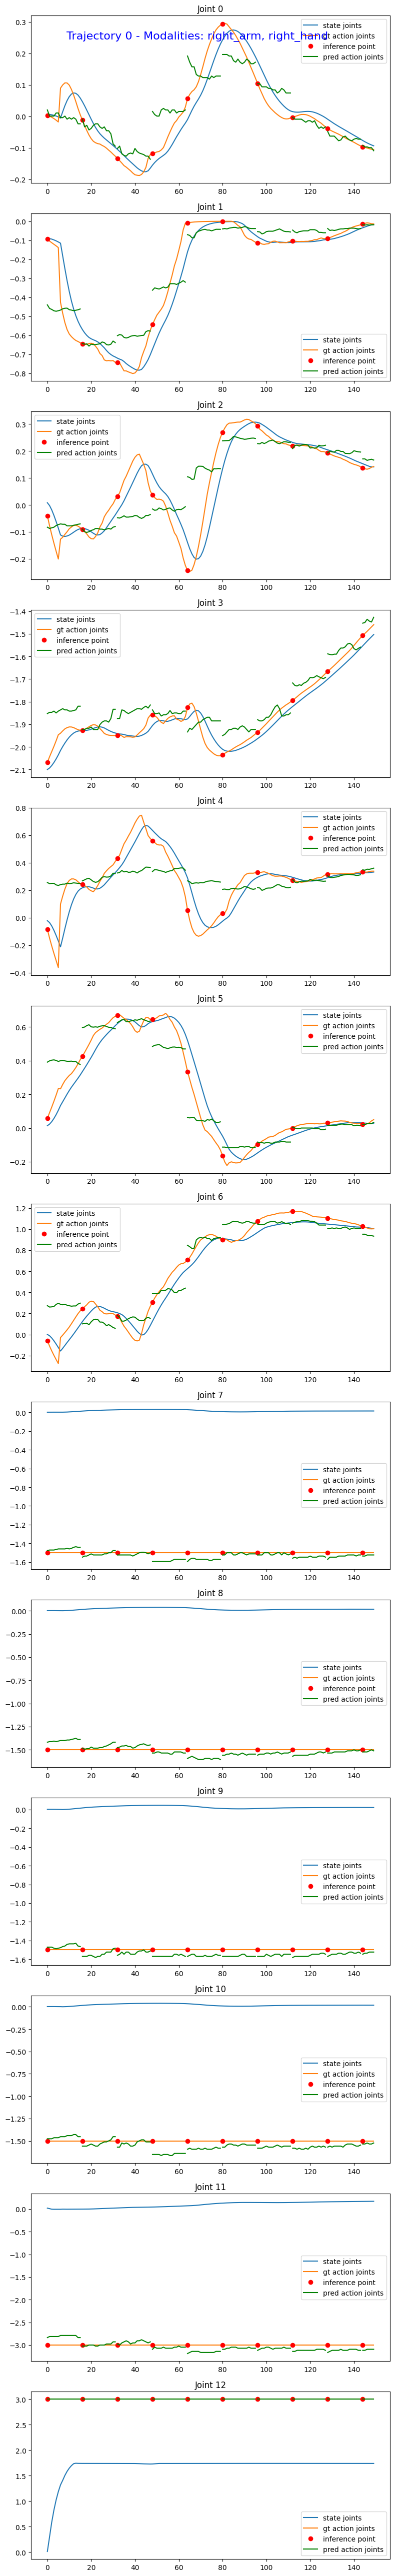

MSE loss for trajectory 0: 0.009579598393423244


In [8]:
from gr00t.utils.eval import calc_mse_for_single_trajectory
import warnings

finetuned_model_path = "../../checkpoints/l2_gr00t-with-past-actions/finetuned-model/checkpoint-2000"
finetuned_policy = L1Gr00tPolicy(
    l1_model_path=finetuned_model_path,
    model_path=finetuned_model_path,
    embodiment_tag="new_embodiment",
    modality_config=modality_config, 
    modality_transform=modality_transform,
    device=device,
)

warnings.simplefilter("ignore", category=FutureWarning)

mse = calc_mse_for_single_trajectory(
    finetuned_policy,
    dataset,
    traj_id=0,
    modality_keys=["right_arm", "right_hand"],   # we will only evaluate the right arm and right hand
    steps=150,
    action_horizon=16,
    plot=True
)

print("MSE loss for trajectory 0:", mse)